**Project Summary**

In our project, we aimed to classify credit card applicants as potentially good or bad customers. Our dataset consists of personal information of previously approved applicants and their historical credit card records. Customers who had overdue bills for more than two months were defined as bad customers while the others as good customers. This allowed us to perform supervised learning. 

**What this notebook contains**

This notebook will contain code relevant to the logistic regression model.  

# Load files and Import packages

In [2]:
## Math
from math import floor
from statistics import *

## Handling Arrays and Dataframes
import pandas as pd
import numpy as np

## One Hot Encoding
from sklearn.preprocessing import OneHotEncoder

## Train Test Set Splitting
from sklearn.model_selection import train_test_split

## Sampling
from imblearn.over_sampling import SMOTENC
from sklearn.utils import resample

## Feature Scaling
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler

## Model Train and Testing
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met 
import matplotlib.pyplot as plt

## PCA
from sklearn.decomposition import PCA

## Fine-tuning
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

## LIME 
!pip install lime
import lime
import lime.lime_tabular

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=afe7d61246824980c18b227050e5727a80b4984bd6713198be8339b3d749e149
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
## mount drive and retrieve labelled data

from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/CS3244") 

cc_data_raw = pd.read_csv("cc_data.csv")
cc_data_raw = cc_data_raw.iloc[:,1:]
cc_data_raw.reset_index(drop = True, inplace = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

## Remove correlated variables

In [4]:
cc_data_raw.head()

ID  CNT_CHILDREN  AMT_INCOME_TOTAL      NAME_INCOME_TYPE  \
0  5008804             0          427500.0               Working   
1  5008805             0          427500.0               Working   
2  5008806             0          112500.0               Working   
3  5008808             0          270000.0  Commercial associate   
4  5008809             0          270000.0  Commercial associate   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0               Higher education        Civil marriage   Rented apartment   
1               Higher education        Civil marriage   Rented apartment   
2  Secondary / secondary special               Married  House / apartment   
3  Secondary / secondary special  Single / not married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
0      -12005          -4542           1                1           0   
1      -12005          -4542           1                1           0   
2      -21474          -1134           1                0           0   
3      -19110          -3051           1                0           1   
4      -19110          -3051           1                0           1   

   FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  Gender  Has_Car  Has_Realty  \
0           0         Unknown              2.0       1        1           1   
1           0         Unknown              2.0       1        1           1   
2           0  Security staff              2.0       1        1           1   
3           1     Sales staff              1.0       0        0           1   
4           1     Sales staff              1.0       0        0           1   

   REALTYPE  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

In [5]:
cc_data_raw["Days_Employed"] = np.maximum(-cc_data_raw.DAYS_EMPLOYED, 0)
cc_data_raw["Days_Birth"] = -cc_data_raw.DAYS_BIRTH

cc_data_raw.drop("DAYS_BIRTH", axis = 1, inplace = True)
cc_data_raw.drop("DAYS_EMPLOYED", axis = 1, inplace = True)

cc_data_raw.drop("ID", axis = 1, inplace = True)
cc_data_raw.drop("FLAG_MOBIL", axis = 1, inplace = True) # only has value 1

In [6]:
corr = cc_data_raw.corr()
corr.style.background_gradient(cmap='coolwarm')

In [7]:
cc_data_raw.drop("CNT_CHILDREN", axis = 1, inplace = True)

In [8]:
corr = cc_data_raw.corr()
corr.style.background_gradient(cmap='coolwarm')

## One Hot Encode categorical data

In [9]:
print(cc_data_raw.shape)

(36105, 16)


In [10]:
cc_data_raw.head()

AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_WORK_PHONE  FLAG_PHONE  \
0        Civil marriage   Rented apartment                1           0   
1        Civil marriage   Rented apartment                1           0   
2               Married  House / apartment                0           0   
3  Single / not married  House / apartment                0           1   
4  Single / not married  House / apartment                0           1   

   FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  Gender  Has_Car  Has_Realty  \
0           0         Unknown              2.0       1        1           1   
1           0         Unknown              2.0       1        1           1   
2           0  Security staff              2.0       1        1           1   
3           1     Sales staff              1.0       0        0           1   
4           1     Sales staff              1.0       0        0           1   

   REALTYPE  Days_Employed  Days_Birth  
0       0.0           4542       12005  
1       0.0           4542       12005  
2       0.0           1134       21474  
3       0.0           3051       19110  
4       0.0           3051       19110

In [11]:
cc_data_ohe = cc_data_raw.copy()

cateogorical_list = ["NAME_EDUCATION_TYPE", "OCCUPATION_TYPE", "NAME_INCOME_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]

for col in cateogorical_list:

    holder = cc_data_ohe[col].values.reshape(-1, 1)

    onehot_encoder = OneHotEncoder(sparse=False)

    temp = pd.DataFrame(onehot_encoder.fit_transform(holder))

    temp.columns = onehot_encoder.get_feature_names_out([col])

    cc_data_ohe = cc_data_ohe.join(temp)

In [12]:
cc_data_ohe.drop("NAME_EDUCATION_TYPE", axis = 1, inplace = True)
cc_data_ohe.drop("OCCUPATION_TYPE", axis = 1, inplace = True)
cc_data_ohe.drop("NAME_INCOME_TYPE", axis = 1, inplace = True)
cc_data_ohe.drop("NAME_FAMILY_STATUS", axis = 1, inplace = True)
cc_data_ohe.drop("NAME_HOUSING_TYPE", axis = 1, inplace = True)

In [13]:
print(cc_data_ohe.shape)

(36105, 51)


In [14]:
cc_data_ohe.head()

AMT_INCOME_TOTAL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0          427500.0                1           0           0              2.0   
1          427500.0                1           0           0              2.0   
2          112500.0                0           0           0              2.0   
3          270000.0                0           1           1              1.0   
4          270000.0                0           1           1              1.0   

   Gender  Has_Car  Has_Realty  REALTYPE  Days_Employed  ...  \
0       1        1           1       0.0           4542  ...   
1       1        1           1       0.0           4542  ...   
2       1        1           1       0.0           1134  ...   
3       0        0           1       0.0           3051  ...   
4       0        0           1       0.0           3051  ...   

   NAME_FAMILY_STATUS_Married  NAME_FAMILY_STATUS_Separated  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         1.0                           0.0   
3                         0.0                           0.0   
4                         0.0                           0.0   

   NAME_FAMILY_STATUS_Single / not married  NAME_FAMILY_STATUS_Widow  \
0                                      0.0                       0.0   
1                                      0.0                       0.0   
2                                      0.0                       0.0   
3                                      1.0                       0.0   
4                                      1.0                       0.0   

   NAME_HOUSING_TYPE_Co-op apartment  NAME_HOUSING_TYPE_House / apartment  \
0                                0.0                                  0.0   
1                                0.0                                  0.0   
2                                0.0                                  1.0   
3                                0.0                                  1.0   
4                                0.0                                  1.0   

   NAME_HOUSING_TYPE_Municipal apartment  NAME_HOUSING_TYPE_Office apartment  \
0                                    0.0                                 0.0   
1                                    0.0                                 0.0   
2                                    0.0                                 0.0   
3                                    0.0                                 0.0   
4                                    0.0                                 0.0   

   NAME_HOUSING_TYPE_Rented apartment  NAME_HOUSING_TYPE_With parents  
0                                 1.0                             0.0  
1                                 1.0                             0.0  
2                                 0.0                             0.0  
3                                 0.0                             0.0  
4                                 0.0                             0.0  

[5 rows x 51 columns]

In [15]:
corr = cc_data_ohe.corr()
corr.style.background_gradient(cmap='coolwarm')

## Split data into Train-Test (Stratified 80/20)

In [16]:
y = cc_data_ohe[["REALTYPE"]] # labels

X = cc_data_ohe.copy() # features
X.drop("REALTYPE", axis = 1, inplace = True) 

trng_X, test_X, trng_y, test_y = train_test_split(X, y, test_size = 0.20, random_state = 3244, stratify = y) 

trng_data = trng_y.join(trng_X)
test_data = test_y.join(test_X)

trng_X_og = trng_X.copy()
test_X_og = test_X.copy()

In [17]:
print(trng_X.shape)
print(test_X.shape)

(28884, 50)
(7221, 50)


## Scale data

In [18]:
## data normalisation - new_x = (x – min) / (max – min)
mm = MinMaxScaler()
trng_X = mm.fit_transform(trng_X)
test_X = mm.fit_transform(test_X)

# Logistic Regression Model

## Setup of helper function and dataframes to store results


We have a cross validation helper function below to remember the indexes that make up the best training set during cross validation.

In [19]:
def get_best(training_x, training_y, model):
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=3244)
  lst_f1_stratified = []
  best_f1 = 0
  best_x_fold = []
  best_y_fold = []
  for train_index, val_index in skf.split(training_x, training_y):
    
      x_train_fold, x_val_fold = training_x[train_index], training_x[val_index]
      y_train_fold, y_val_fold = training_y.values.ravel()[train_index], training_y.values.ravel()[val_index]

      if len(best_x_fold) == 0:
        best_x_fold.extend(x_train_fold)
        best_y_fold.extend(y_train_fold) 

      lr = model.fit(x_train_fold, y_train_fold)

      current_model_f1 = met.f1_score(y_true = y_val_fold, y_pred = model.predict(x_val_fold))
      lst_f1_stratified.append(current_model_f1)

      if current_model_f1 > best_f1:
        best_x_fold.clear()
        best_y_fold.clear()
        best_x_fold.extend(x_train_fold)
        best_y_fold.extend(y_train_fold) 

  print('List of possible F1-score:', [round(x, 5) for x in lst_f1_stratified])
  print('\nMaximum F1-score That can be obtained from this model is:', round(max(lst_f1_stratified)*100, 5), '%')
  print('\nMinimum F1-score:', round(min(lst_f1_stratified)*100, 5), '%')
  print('\nAverage F1-score:', round(mean(lst_f1_stratified), 5), '%')
  print('\nStandard Deviation is:', round(stdev(lst_f1_stratified), 5))

  return (best_x_fold, best_y_fold)

We define two variables to store model performance during training and testing.

In [20]:
## make predictions and compute metrics
# 1) we want to maximise f1 score - 2/(1/P + 1/R)
# 2) cfm.ravel() - tn, fp, fn, tp
# 3) class-specific accuracy for reference

column_template = {"model": [], "roc auc score": [],
                   "F1-score": [], "precision": [], "recall" : [],
                   "tn": [], "fp": [], "fn": [], "tp": [], 
                   "class 0 accuracy": [], "class 1 accuracy ": []}

training_results = pd.DataFrame(column_template)
testing_results = pd.DataFrame(column_template)

## 1) Plain Model

Use cross validation to get subset of training data with best F1-score on validation set. (Here, cross validation does not help due to extreme class imbalance in training data and bias towards majority class not controlled.)

In [21]:
# fit model
clf = LogisticRegression(random_state = 3244, max_iter = 500)

# CV
best_fold = get_best(trng_X, trng_y, clf)

List of possible F1-score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Maximum F1-score That can be obtained from this model is: 0.0 %

Minimum F1-score: 0.0 %

Average F1-score: 0.0 %

Standard Deviation is: 0.0


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [22]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         max_iter = 500).fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_1 = {"model": "plain",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision" : met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_1, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_1 = {"model": "plain",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_1, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model is overly biased towards majority class, does not predict minority class at all. Model does not learn well, leading to poor testing performance subsequently.

In [23]:
training_results

model  roc auc score  F1-score  precision  recall       tn   fp     fn  \
0  plain            0.5       0.0        0.0     0.0  25805.0  0.0  190.0   

    tp  class 0 accuracy  class 1 accuracy   
0  0.0               1.0                0.0

In [24]:
testing_results

model  roc auc score  F1-score  precision  recall      tn   fp    fn   tp  \
0  plain            0.5       0.0        0.0     0.0  7168.0  0.0  53.0  0.0   

   class 0 accuracy  class 1 accuracy   
0               1.0                0.0

## 2) Weighted Model

Make loss function weighted such that misclassifications of minority class examples have higher cost. 

Use cross validation to get subset of training data with best F1-score on validation set. 

In [25]:
# fit model
clf = LogisticRegression(random_state = 3244, max_iter = 500, class_weight = "balanced")

# CV
best_fold = get_best(trng_X, trng_y, clf)

List of possible F1-score: [0.01481, 0.0191, 0.01663, 0.01711, 0.01408, 0.022, 0.01795, 0.02829, 0.02536, 0.01704]

Maximum F1-score That can be obtained from this model is: 2.82862 %

Minimum F1-score: 1.40845 %

Average F1-score: 0.01924 %

Standard Deviation is: 0.00461


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [26]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         max_iter = 500, class_weight = "balanced").fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_1 = {"model": "weighted",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision" : met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_1, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_1 = {"model": "weighted",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_1, ignore_index = True)

Model makes some minority class predictions, correctly identifying 27 bad customers out of 53. Huge improvement from plain model. 

In [27]:
training_results

model  roc auc score  F1-score  precision    recall       tn       fp  \
0     plain       0.500000  0.000000   0.000000  0.000000  25805.0      0.0   
1  weighted       0.615936  0.022693   0.011556  0.626316  15627.0  10179.0   

      fn     tp  class 0 accuracy  class 1 accuracy   
0  190.0    0.0          1.000000           0.000000  
1   71.0  119.0          0.605557           0.626316

In [28]:
testing_results

model  roc auc score  F1-score  precision    recall      tn      fp  \
0     plain       0.500000  0.000000   0.000000  0.000000  7168.0     0.0   
1  weighted       0.524597  0.015981   0.008118  0.509434  3869.0  3299.0   

     fn    tp  class 0 accuracy  class 1 accuracy   
0  53.0   0.0           1.00000           0.000000  
1  26.0  27.0           0.53976           0.509434

## 3) Model with undersampled majority class and oversampled minority class

Mitigate class imbalance's effect on model training by resampling more minority class examples and less majority class examples.

In [29]:
trng_data.REALTYPE.value_counts()

0.0    28673
1.0      211
Name: REALTYPE, dtype: int64

Sample majority class by a factor of 1/5, sample minority class by a factor of 5.

In [30]:
# Separate majority and minority classes
trng_data_major = trng_data[trng_data.REALTYPE == 0]
trng_data_minor = trng_data[trng_data.REALTYPE == 1]

# Downsample majority class 
trng_data_major_resampled = resample(trng_data_major, 
                                 replace = False,
                                 n_samples = floor(28673/5),
                                 random_state = 3244)

# Upsample minority class
trng_data_minor_resampled = resample(trng_data_minor, 
                                 replace = True,
                                 n_samples = 211*5,
                                 random_state = 3244)

# Combine minority class with downsampled majority class
trng_data_resampled = pd.concat([trng_data_major_resampled, trng_data_minor_resampled])

In [31]:
trng_data_resampled.REALTYPE.value_counts()

0.0    5734
1.0    1055
Name: REALTYPE, dtype: int64

In [32]:
y_train_resampled = trng_data_resampled["REALTYPE"]
X_train_resampled = trng_data_resampled.drop("REALTYPE", axis = 1)
X_train_resampled = mm.fit_transform(X_train_resampled)

Use cross validation to get subset of training data with best F1-score on validation set. 

In [33]:
# fit model
clf = LogisticRegression(random_state = 3244, max_iter = 500, class_weight = "balanced")

# CV
best_fold = get_best(X_train_resampled, y_train_resampled, clf)

List of possible F1-score: [0.33773, 0.31807, 0.31053, 0.34646, 0.33943, 0.36725, 0.35233, 0.35821, 0.29333, 0.315]

Maximum F1-score That can be obtained from this model is: 36.72457 %

Minimum F1-score: 29.33333 %

Average F1-score: 0.33383 %

Standard Deviation is: 0.02368


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [34]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         max_iter = 500, class_weight = "balanced").fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_1 = {"model": "weighted and resampled",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision" : met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_1, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_1 = {"model": "weighted and resampled",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_1, ignore_index = True)

During training, model precision and recall improved, suggesting that model learnt more patterns to distinguish the two classes. However, testing results show that this may not be the case; we may have overfitted the model to the resampled training data which has lost significant signal information, leading to worse testing performance.

In [35]:
training_results

model  roc auc score  F1-score  precision    recall  \
0                   plain       0.500000  0.000000   0.000000  0.000000   
1                weighted       0.615936  0.022693   0.011556  0.626316   
2  weighted and resampled       0.635042  0.350575   0.241107  0.642105   

        tn       fp     fn     tp  class 0 accuracy  class 1 accuracy   
0  25805.0      0.0  190.0    0.0          1.000000           0.000000  
1  15627.0  10179.0   71.0  119.0          0.605557           0.626316  
2   3241.0   1920.0  340.0  610.0          0.627979           0.642105

In [36]:
testing_results

model  roc auc score  F1-score  precision    recall  \
0                   plain       0.500000  0.000000   0.000000  0.000000   
1                weighted       0.524597  0.015981   0.008118  0.509434   
2  weighted and resampled       0.472548  0.011056   0.005695  0.188679   

       tn      fp    fn    tp  class 0 accuracy  class 1 accuracy   
0  7168.0     0.0  53.0   0.0          1.000000           0.000000  
1  3869.0  3299.0  26.0  27.0          0.539760           0.509434  
2  5422.0  1746.0  43.0  10.0          0.756417           0.188679

## 4) Model with undersampled majority class and SMOTE-oversampled minority class

Attempt less aggressive majority class downsampling and use SMOTE to increase minority class examples in training data.

In [37]:
trng_data.REALTYPE.value_counts()

0.0    28673
1.0      211
Name: REALTYPE, dtype: int64

Sample majority class by a factor of 2/5

In [38]:
# Separate majority and minority classes
trng_data_major = trng_data[trng_data.REALTYPE == 0]
trng_data_minor = trng_data[trng_data.REALTYPE == 1]

# Downsample majority class 
trng_data_major_resampled = resample(trng_data_major, 
                                 replace = False,
                                 n_samples = floor(28673*2/5),
                                 random_state = 3244)
# Combine 
trng_data_resampled = pd.concat([trng_data_major_resampled, trng_data_minor])

In [39]:
trng_data_resampled.REALTYPE.value_counts()

0.0    11469
1.0      211
Name: REALTYPE, dtype: int64

In [40]:
y_train_resampled = trng_data_resampled["REALTYPE"]
X_train_resampled = trng_data_resampled.drop("REALTYPE", axis = 1)
X_train_resampled = mm.fit_transform(X_train_resampled)

Identify categorical features for SMOTENC (SMOTE variant) data augmentation.

In [41]:
trng_X_og.columns

Index(['AMT_INCOME_TOTAL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'Gender', 'Has_Car', 'Has_Realty', 'Days_Employed',
       'Days_Birth', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cleaning staff',
       'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR staff',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_IT staff',
       'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_Secretaries', 'OCCUPAT

In [42]:
a = list(range(0, 50)) # idx of all var
non_cat = [0, 4, 8, 9]
cat = [i for i in a if i not in non_cat]

Sample minority class using SMOTENC such that post-sampling ratio is around 1 minority:10 majority and minority class is sampled by a factor of around 5.

In [43]:
sm = SMOTENC(random_state = 3244, categorical_features = cat, sampling_strategy = 0.1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_resampled, y_train_resampled)

In [44]:
y_train_resampled.value_counts()

0.0    11469
1.0     1146
Name: REALTYPE, dtype: int64

Use cross validation to get subset of training data with best F1-score on validation set. 

In [45]:
# fit model
clf = LogisticRegression(random_state = 3244, max_iter = 500, class_weight = "balanced")

# CV
best_fold = get_best(X_train_resampled, y_train_resampled, clf)

List of possible F1-score: [0.34686, 0.3513, 0.31919, 0.32, 0.36175, 0.32766, 0.31703, 0.34343, 0.31537, 0.34195]

Maximum F1-score That can be obtained from this model is: 36.17464 %

Minimum F1-score: 31.53693 %

Average F1-score: 0.33445 %

Standard Deviation is: 0.01658


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [46]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         max_iter = 500, class_weight = "balanced").fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_1 = {"model": "weighted and resampled w SMOTE",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision" : met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_1, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_1 = {"model": "weighted and resampled w SMOTE",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_1, ignore_index = True)

Testing results indicate that the less aggressive downsampling of majority class examples helped to retain more signal information, resulting in more correctly predicted negatives. During training, the model was also able to capture more true positive cases, which could support synthesising new data using SMOTE compared to sampling from available minority class data, although the effect does not seem pronounced in testing results.

In [47]:
training_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.615936  0.022693   0.011556   
2          weighted and resampled       0.635042  0.350575   0.241107   
3  weighted and resampled w SMOTE       0.738623  0.338584   0.219505   

     recall       tn       fp     fn     tp  class 0 accuracy  \
0  0.000000  25805.0      0.0  190.0    0.0          1.000000   
1  0.626316  15627.0  10179.0   71.0  119.0          0.605557   
2  0.642105   3241.0   1920.0  340.0  610.0          0.627979   
3  0.740058   7610.0   2713.0  268.0  763.0          0.737189   

   class 1 accuracy   
0           0.000000  
1           0.626316  
2           0.642105  
3           0.740058

In [48]:
testing_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.524597  0.015981   0.008118   
2          weighted and resampled       0.472548  0.011056   0.005695   
3  weighted and resampled w SMOTE       0.490074  0.012987   0.006703   

     recall      tn      fp    fn    tp  class 0 accuracy  class 1 accuracy   
0  0.000000  7168.0     0.0  53.0   0.0          1.000000           0.000000  
1  0.509434  3869.0  3299.0  26.0  27.0          0.539760           0.509434  
2  0.188679  5422.0  1746.0  43.0  10.0          0.756417           0.188679  
3  0.207547  5538.0  1630.0  42.0  11.0          0.772600           0.207547

## 5) Weighted model using PCA components as predictors

We attempt PCA to reduce dimensions of predictors before model training.

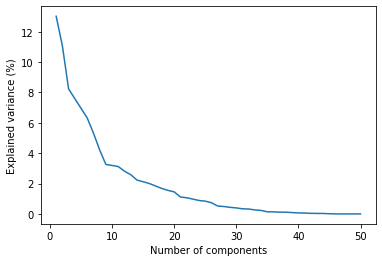

In [49]:
components = None
pca = PCA(n_components = components)
pca.fit(trng_X)

# print percentage of variance explained by each principal component
# print(f"Variances (Percentage): {pca.explained_variance_ratio_ * 100}")

# print cumsum percentage of variance 
# print(f"Cumulative Variances (Percentage): {pca.explained_variance_ratio_.cumsum() * 100}")

# scree plot
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

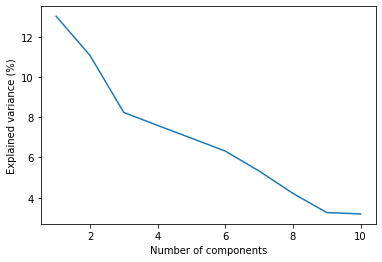

In [50]:
# refit pca using only a subset of components s.t. x% of variance explained or x number of components, mitigate overfit
pca = PCA(n_components = 10)
pca.fit(trng_X)

# print(f"Cumulative Variances (Percentage): {pca.explained_variance_ratio_.cumsum() * 100}")

components = len(pca.explained_variance_ratio_)
# print(f"Number of components: {components}")

# scree plot
plt.plot(range(1, components + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

In [51]:
trng_X_PCA = pca.transform(trng_X)
test_X_PCA = pca.transform(test_X)

Use cross validation to get subset of training data with best F1-score on validation set. 

In [52]:
clf = LogisticRegression(random_state = 3244, 
                         class_weight = "balanced")

best_fold = get_best(trng_X_PCA, trng_y, clf)

List of possible F1-score: [0.01305, 0.01455, 0.01931, 0.01884, 0.01474, 0.01839, 0.01333, 0.02191, 0.01826, 0.01787]

Maximum F1-score That can be obtained from this model is: 2.19092 %

Minimum F1-score: 1.30506 %

Average F1-score: 0.01703 %

Standard Deviation is: 0.00293


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [53]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X_PCA
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         class_weight = "balanced").fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_3 = {"model": "weighted and PCA",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision": met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_3, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_3 = {"model": "weighted and PCA",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_3, ignore_index = True)

It seems that for our data, variation in the features were not sufficiently strongly associated with variation in the response. Precision during training suffered a huge drop due to the rise in number of false positives. Or it could be that we have not select enough components to account for the variation, resulting in underfitting. 



In [54]:
training_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.615936  0.022693   0.011556   
2          weighted and resampled       0.635042  0.350575   0.241107   
3  weighted and resampled w SMOTE       0.738623  0.338584   0.219505   
4                weighted and PCA       0.584805  0.020113   0.010231   

     recall       tn       fp     fn     tp  class 0 accuracy  \
0  0.000000  25805.0      0.0  190.0    0.0          1.000000   
1  0.626316  15627.0  10179.0   71.0  119.0          0.605557   
2  0.642105   3241.0   1920.0  340.0  610.0          0.627979   
3  0.740058   7610.0   2713.0  268.0  763.0          0.737189   
4  0.589474  14971.0  10835.0   78.0  112.0          0.580136   

   class 1 accuracy   
0           0.000000  
1           0.626316  
2           0.642105  
3           0.740058  
4           0.589474

In [55]:
testing_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.524597  0.015981   0.008118   
2          weighted and resampled       0.472548  0.011056   0.005695   
3  weighted and resampled w SMOTE       0.490074  0.012987   0.006703   
4                weighted and PCA       0.474324  0.012715   0.006466   

     recall      tn      fp    fn    tp  class 0 accuracy  class 1 accuracy   
0  0.000000  7168.0     0.0  53.0   0.0          1.000000           0.000000  
1  0.509434  3869.0  3299.0  26.0  27.0          0.539760           0.509434  
2  0.188679  5422.0  1746.0  43.0  10.0          0.756417           0.188679  
3  0.207547  5538.0  1630.0  42.0  11.0          0.772600           0.207547  
4  0.377358  4095.0  3073.0  33.0  20.0          0.571289           0.377358

## 6) Weighted model using PCA components as predictors (80% Variance)

In the previous section, less than 70% of the variance was accounted for by the principal components chosen. Here, we choose the number of principal components such that at least 80% of the variance is explained. 

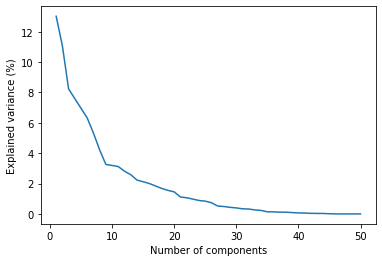

In [56]:
components = None
pca = PCA(n_components = components)
pca.fit(trng_X)

# print percentage of variance explained by each principal component
# print(f"Variances (Percentage): {pca.explained_variance_ratio_ * 100}")

# print cumsum percentage of variance 
# print(f"Cumulative Variances (Percentage): {pca.explained_variance_ratio_.cumsum() * 100}")

# scree plot
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

In [57]:
# refit pca using only a subset of components s.t. x% of variance explained or x number of components, mitigate overfit
pca = PCA(n_components = 0.8)
pca.fit(trng_X)

# print(f"Cumulative Variances (Percentage): {pca.explained_variance_ratio_.cumsum() * 100}")

components = len(pca.explained_variance_ratio_)
# print(f"Number of components: {components}")

# scree plot
plt.plot(range(1, components + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.show()

In [58]:
trng_X_PCA = pca.transform(trng_X)
test_X_PCA = pca.transform(test_X)

Use cross validation to get subset of training data with best F1-score on validation set. 

In [59]:
clf = LogisticRegression(random_state = 3244, 
                         class_weight = "balanced")

best_fold = get_best(trng_X_PCA, trng_y, clf)

List of possible F1-score: [0.01236, 0.01304, 0.01253, 0.01717, 0.01472, 0.02191, 0.01433, 0.02313, 0.01692, 0.01336]

Maximum F1-score That can be obtained from this model is: 2.31303 %

Minimum F1-score: 1.23648 %

Average F1-score: 0.01595 %

Standard Deviation is: 0.00385


Train model using subset of data identified above using cross validation and Test model using holdout set.

In [60]:
X_train = best_fold[0]
y_train = best_fold[1]
X_test = test_X_PCA
y_test = test_y

# fit model
clf = LogisticRegression(random_state = 3244, 
                         class_weight = "balanced").fit(X_train, y_train)

cfm = met.confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
train_3 = {"model": "weighted and PCA (80%)",
  "roc auc score": met.roc_auc_score(y_true = y_train, y_score = clf.predict(X_train)),
	"F1-score": met.f1_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "precision": met.precision_score(y_true = y_train, y_pred = clf.predict(X_train)),
  "recall": met.recall_score(y_true = y_train, y_pred = clf.predict(X_train)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
training_results = training_results.append(train_3, ignore_index = True)

cfm = met.confusion_matrix(y_true = y_test, y_pred = clf.predict(X_test))
cfm2 = cfm.astype("float") / cfm.sum(axis=1)[:, np.newaxis]
test_3 = {"model": "weighted and PCA (80%)",
  "roc auc score": met.roc_auc_score(y_true = y_test, y_score = clf.predict(X_test)),
	"F1-score": met.f1_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "precision": met.precision_score(y_true = y_test, y_pred = clf.predict(X_test)),
  "recall": met.recall_score(y_true = y_test, y_pred = clf.predict(X_test)),
	"tn": cfm.ravel()[0],
	"fp": cfm.ravel()[1],
  "fn": cfm.ravel()[2],
  "tp": cfm.ravel()[3],
  "class 0 accuracy": cfm2.diagonal()[0],
  "class 1 accuracy ": cfm2.diagonal()[1]}
testing_results = testing_results.append(test_3, ignore_index = True)

It turns out that we were not underfitting, but overfitting. Increasing the number of principal components here only exacerbated the situation. The noise in our data was underestimated.  



In [61]:
training_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.615936  0.022693   0.011556   
2          weighted and resampled       0.635042  0.350575   0.241107   
3  weighted and resampled w SMOTE       0.738623  0.338584   0.219505   
4                weighted and PCA       0.584805  0.020113   0.010231   
5          weighted and PCA (80%)       0.558741  0.018355   0.009337   

     recall       tn       fp     fn     tp  class 0 accuracy  \
0  0.000000  25805.0      0.0  190.0    0.0          1.000000   
1  0.626316  15627.0  10179.0   71.0  119.0          0.605557   
2  0.642105   3241.0   1920.0  340.0  610.0          0.627979   
3  0.740058   7610.0   2713.0  268.0  763.0          0.737189   
4  0.589474  14971.0  10835.0   78.0  112.0          0.580136   
5  0.536842  14984.0  10822.0   88.0  102.0          0.580640   

   class 1 accuracy   
0           0.000000  
1           0.626316  
2           0.642105  
3           0.740058  
4           0.589474  
5           0.536842

In [62]:
testing_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.524597  0.015981   0.008118   
2          weighted and resampled       0.472548  0.011056   0.005695   
3  weighted and resampled w SMOTE       0.490074  0.012987   0.006703   
4                weighted and PCA       0.474324  0.012715   0.006466   
5          weighted and PCA (80%)       0.466285  0.012160   0.006185   

     recall      tn      fp    fn    tp  class 0 accuracy  class 1 accuracy   
0  0.000000  7168.0     0.0  53.0   0.0          1.000000           0.000000  
1  0.509434  3869.0  3299.0  26.0  27.0          0.539760           0.509434  
2  0.188679  5422.0  1746.0  43.0  10.0          0.756417           0.188679  
3  0.207547  5538.0  1630.0  42.0  11.0          0.772600           0.207547  
4  0.377358  4095.0  3073.0  33.0  20.0          0.571289           0.377358  
5  0.358491  4115.0  3053.0  34.0  19.0          0.574079           0.358491

## Fine-tuning of selected model

For our data, the best model currently is the weighted model. 

In [63]:
training_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.615936  0.022693   0.011556   
2          weighted and resampled       0.635042  0.350575   0.241107   
3  weighted and resampled w SMOTE       0.738623  0.338584   0.219505   
4                weighted and PCA       0.584805  0.020113   0.010231   
5          weighted and PCA (80%)       0.558741  0.018355   0.009337   

     recall       tn       fp     fn     tp  class 0 accuracy  \
0  0.000000  25805.0      0.0  190.0    0.0          1.000000   
1  0.626316  15627.0  10179.0   71.0  119.0          0.605557   
2  0.642105   3241.0   1920.0  340.0  610.0          0.627979   
3  0.740058   7610.0   2713.0  268.0  763.0          0.737189   
4  0.589474  14971.0  10835.0   78.0  112.0          0.580136   
5  0.536842  14984.0  10822.0   88.0  102.0          0.580640   

   class 1 accuracy   
0           0.000000  
1           0.626316  
2           0.642105  
3           0.740058  
4           0.589474  
5           0.536842

In [64]:
testing_results

model  roc auc score  F1-score  precision  \
0                           plain       0.500000  0.000000   0.000000   
1                        weighted       0.524597  0.015981   0.008118   
2          weighted and resampled       0.472548  0.011056   0.005695   
3  weighted and resampled w SMOTE       0.490074  0.012987   0.006703   
4                weighted and PCA       0.474324  0.012715   0.006466   
5          weighted and PCA (80%)       0.466285  0.012160   0.006185   

     recall      tn      fp    fn    tp  class 0 accuracy  class 1 accuracy   
0  0.000000  7168.0     0.0  53.0   0.0          1.000000           0.000000  
1  0.509434  3869.0  3299.0  26.0  27.0          0.539760           0.509434  
2  0.188679  5422.0  1746.0  43.0  10.0          0.756417           0.188679  
3  0.207547  5538.0  1630.0  42.0  11.0          0.772600           0.207547  
4  0.377358  4095.0  3073.0  33.0  20.0          0.571289           0.377358  
5  0.358491  4115.0  3053.0  34.0  19.0          0.574079           0.358491

### Regularisation

In [65]:
# define dataset
X, y = trng_X, trng_y.values.ravel()

# define models and parameters
clf = LogisticRegression(random_state = 3244, max_iter = 500, class_weight = "balanced")

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.02, 0.01, 0.005]

# define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 3244)
grid_search = GridSearchCV(estimator = clf, param_grid = grid, 
                           n_jobs = -1, cv = cv, 
                           scoring = 'f1', error_score = 0)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.019174 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


In [66]:
optimal_weights = grid_search.best_params_
optimal_weights

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

### Weights in weighted loss function

In [67]:
balanced_cw_0 = len(trng_data)/(2*trng_data.REALTYPE.value_counts()[0.0]) # weights using "balanced"
balanced_cw_1 = len(trng_data)/(2*trng_data.REALTYPE.value_counts()[1.0]) # weights using "balanced"
class_wgt = [{1:balanced_cw_1*w, 0:balanced_cw_0*(1/w)} for w in np.linspace(1,10,11,endpoint=True)]
class_wgt

[{1: 68.44549763033176, 0: 0.5036794196630977},
 {1: 130.04644549763034, 0: 0.26509443140163036},
 {1: 191.64739336492892, 0: 0.1798855070225349},
 {1: 253.24834123222752, 0: 0.13612957288191826},
 {1: 314.84928909952606, 0: 0.1094955260137169},
 {1: 376.45023696682466, 0: 0.0915780763023814},
 {1: 438.05118483412326, 0: 0.07869990932235901},
 {1: 499.6521327014218, 0: 0.0689971807757668},
 {1: 561.2530805687204, 0: 0.06142431947110948},
 {1: 622.854028436019, 0: 0.055349386776164584},
 {1: 684.4549763033176, 0: 0.050367941966309775}]

In [68]:
# define dataset
X, y = trng_X, trng_y.values.ravel()

# define models and parameters
clf = LogisticRegression(random_state = 3244, max_iter = 500,
                         C = 1.0, penalty = "l2",
                         solver = "liblinear")

# define grid search
grid = dict(class_weight = class_wgt)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 3244)
grid_search = GridSearchCV(estimator = clf, param_grid = grid, 
                           n_jobs = -1, cv = cv, 
                           scoring = 'f1', error_score = 0)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.019176 using {'class_weight': {1: 68.44549763033176, 0: 0.5036794196630977}}


## Inferences based on selected model

In [69]:
clf = LogisticRegression(random_state = 3244, max_iter = 500,
                         C = 1.0, penalty = "l2",
                         solver = "liblinear", class_weight = "balanced").fit(trng_X, trng_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
lgb_weights = pd.DataFrame(clf.coef_, columns = trng_X_og.columns)

The number of family members, days employed, possession of degree education, occupation type, and whether one lives in a co-op apartment have some of the largest weights.

In [71]:
np.transpose(lgb_weights).style.applymap(lambda x: "background-color: orange" if abs(x) > 1.5 else "background-color: white")

In [72]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = np.array(trng_X), 
    feature_names = trng_X_og.columns.values.tolist(),
    verbose = True, mode = "classification",
    random_state = 3244)

j = 3244
print(f"Actual y label: {y_test.values.ravel()[j]}")
exp = explainer.explain_instance(
    data_row = np.array(test_X)[j], 
    predict_fn = clf.predict_proba, 
    num_features = 10)

exp.show_in_notebook(show_table = True)

Actual y label: 0.0
Intercept -0.7927926980704226
Prediction_local [0.40623945]
Right: 0.6781281511268925


In [73]:
exp.as_list() # factors that will change probability of being classified as 1

[('OCCUPATION_TYPE_Cleaning staff <= 0.00', 0.39323371240472077),
 ('OCCUPATION_TYPE_Waiters/barmen staff <= 0.00', 0.33758837254374735),
 ('OCCUPATION_TYPE_High skill tech staff <= 0.00', -0.30909033194523283),
 ('OCCUPATION_TYPE_Realty agents <= 0.00', 0.28327468269458334),
 ('NAME_HOUSING_TYPE_Co-op apartment <= 0.00', 0.28120409435786825),
 ('NAME_EDUCATION_TYPE_Academic degree <= 0.00', 0.2486522086870416),
 ('OCCUPATION_TYPE_HR staff <= 0.00', 0.2405626529890912),
 ('OCCUPATION_TYPE_Security staff <= 0.00', -0.23424505454987074),
 ('OCCUPATION_TYPE_Drivers <= 0.00', -0.23244358985540248),
 ('OCCUPATION_TYPE_IT staff <= 0.00', 0.19029539744722293)]